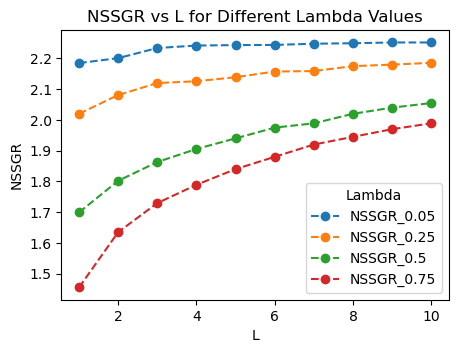

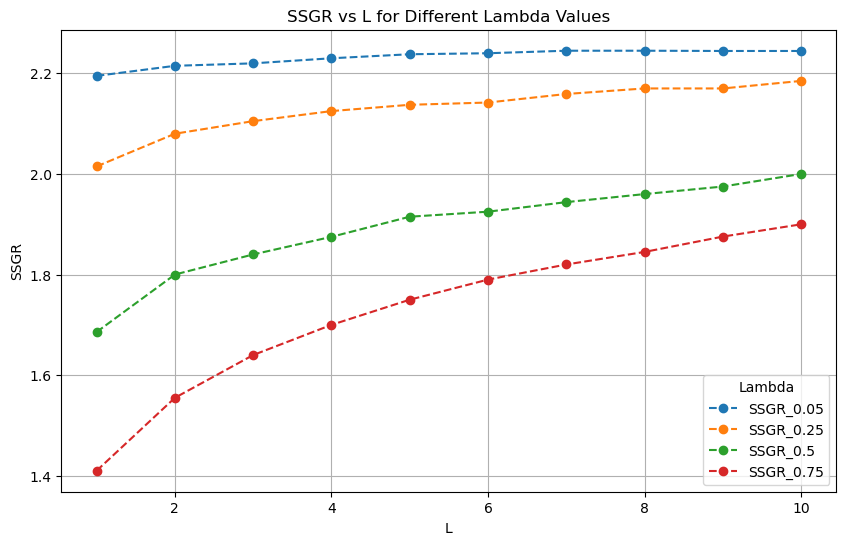

In [5]:
import numpy as numpy
import pandas as pandas
import matplotlib.pyplot as plt

data = {
    'L': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'NSSGR_0.05': [2.185, 2.201, 2.234, 2.242, 2.2435, 2.244, 2.248, 2.2495, 2.252, 2.252],
    'SSGR_0.05': [2.195, 2.215, 2.2199, 2.23, 2.238, 2.24, 2.245, 2.245, 2.2445, 2.2445],
    'NSSGR_0.25': [2.02, 2.081, 2.12, 2.1259, 2.139, 2.1575, 2.159, 2.175, 2.18, 2.1859],
    'SSGR_0.25': [2.015, 2.08, 2.105, 2.125, 2.1375, 2.142, 2.159, 2.17, 2.17, 2.185],
    'NSSGR_0.5': [1.699, 1.802, 1.863, 1.9055, 1.94, 1.975, 1.989, 2.02, 2.04, 2.055],
    'SSGR_0.5': [1.6858, 1.80005, 1.84, 1.875, 1.915, 1.925, 1.944, 1.96, 1.975, 2],
    'NSSGR_0.75': [1.455, 1.635, 1.7295, 1.789, 1.84, 1.88, 1.92, 1.945, 1.97, 1.989],
    'SSGR_0.75': [1.41, 1.555, 1.64, 1.7, 1.75, 1.79, 1.82, 1.845, 1.8755, 1.8999]
}

df = pandas.DataFrame(data)

# Plot for NSSGR
plt.figure(figsize=(5, 3.5))
for col in ['NSSGR_0.05', 'NSSGR_0.25', 'NSSGR_0.5', 'NSSGR_0.75']:
    plt.plot(df['L'], df[col], linestyle='--', marker='o', label=col)
plt.xlabel('L')
plt.ylabel('NSSGR')
plt.title('NSSGR vs L for Different Lambda Values')
plt.legend(title='Lambda')

# Plot for SSGR
plt.figure(figsize=(10, 6))
for col in ['SSGR_0.05', 'SSGR_0.25', 'SSGR_0.5', 'SSGR_0.75']:
    plt.plot(df['L'], df[col], linestyle='--', marker='o', label=col)
plt.xlabel('L')
plt.ylabel('SSGR')
plt.title('SSGR vs L for Different Lambda Values')
plt.legend(title='Lambda')
plt.grid(True)


# NSSGR boxplot

In [10]:
import numpy as numpy
import pandas as pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
m = 100
sim = 2000
n = 5
exp_w = (n * (n + m + 1)) / 2
stdev_w = numpy.sqrt(n * m * (n + m + 1) / 12)
shape_params = [1, 15] 
scale_param = 1

# Lambda and Le values
lambda_values = [0.05, 0.5]
Le_values = [2.234, 1.863]
L_SSGR = 3

# Distributions to test
distributions = [
    ('normal', 0, 1),
    ('t', 5, 0),
    ('t', 20, 0),
    ('gamma', 1, 1),
    ('gamma', 15, 1)
]

# DataFrame to store results
results = pandas.DataFrame(columns=['Lambda', 'Distribution', 'Run_Length'])

for lambda_, Le in zip(lambda_values, Le_values):
    # Control Limits
    LCL = exp_w - Le * stdev_w * numpy.sqrt(lambda_ / (2 - lambda_))
    UCL = exp_w + Le * stdev_w * numpy.sqrt(lambda_ / (2 - lambda_))
    
    for dist, param1, param2 in distributions:
        run_lengths = []
        print(dist, param1, param2)
        for i in tqdm(range(sim)):
            zi_1 = exp_w  # Phase I mean as starting EWMA value
            if dist == 'normal':
                xi = numpy.random.normal(0, 1, m)  # Phase I data Normal
            elif dist == 't':
                xi = numpy.random.standard_t(param1, m)  # Phase I data t
            elif dist == 'gamma':
                xi = numpy.random.gamma(param1, param2, m)  # Phase I data Gamma
                xi = (xi - param1) / numpy.sqrt(param1)
                
            count = 0
            signaled = False
            total_run = 0
            previous_run_length = None
            
            while not signaled:
                count += 1
                total_run += 1
                if dist == 'normal':
                    yi = numpy.random.normal(0, 1, n)  # Phase II data Normal
                elif dist == 't':
                    yi = numpy.random.standard_t(param1, n)  # Phase II data t
                elif dist == 'gamma':
                    yi = numpy.random.gamma(param1, param2, n)  # Phase II data Gamma
                    yi = (yi - param1) / numpy.sqrt(param1)
                    
                comb = numpy.concatenate((xi, yi))
                ranks = numpy.argsort(numpy.argsort(comb)) + 1  # Rank calculation
                W = ranks[-n:].sum()  # Sum of ranks for new sample
    
                # Calculate W-EWMA
                zi = lambda_ * W + (1 - lambda_) * zi_1
                zi_1 = zi
                
                # Check control limits and evaluate run length
                if zi >= UCL or zi <= LCL:
                    if previous_run_length is None:
                        if count <= L_SSGR:
                            run_lengths.append(total_run)
                            signaled = True
                    elif previous_run_length <= L_SSGR and count <= L_SSGR:
                        run_lengths.append(total_run)
                        signaled = True
                    previous_run_length = count
                    count = 0  # Reset count after nonconforming group and no signal
        
        # Store results
        new_rows = pandas.DataFrame({'Lambda': [lambda_] * len(run_lengths), 
                                     'Distribution': [f'{dist} ({param1})'] * len(run_lengths), 
                                     'Run_Length': run_lengths})
        results = pandas.concat([results, new_rows], ignore_index=True)




normal 0 1


100%|██████████| 2000/2000 [00:19<00:00, 102.58it/s]


t 5 0


100%|██████████| 2000/2000 [00:20<00:00, 98.05it/s] 


t 20 0


100%|██████████| 2000/2000 [00:19<00:00, 103.88it/s]


gamma 1 1


100%|██████████| 2000/2000 [00:26<00:00, 76.14it/s] 


gamma 15 1


100%|██████████| 2000/2000 [00:21<00:00, 93.93it/s] 


normal 0 1


100%|██████████| 2000/2000 [00:28<00:00, 69.25it/s] 


t 5 0


100%|██████████| 2000/2000 [00:33<00:00, 60.29it/s]


t 20 0


100%|██████████| 2000/2000 [00:19<00:00, 101.17it/s]


gamma 1 1


100%|██████████| 2000/2000 [00:20<00:00, 95.26it/s] 


gamma 15 1


100%|██████████| 2000/2000 [00:19<00:00, 102.93it/s]


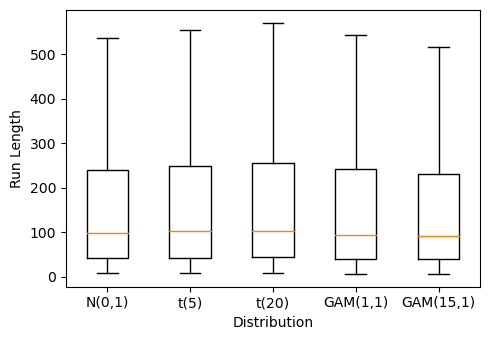

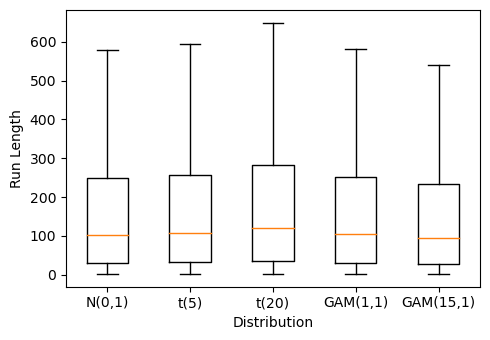

In [17]:
distribution_labels = {
    'normal (0)': 'N(0,1)',
    't (5)': 't(5)',
    't (20)': 't(20)',
    'gamma (1)': 'GAM(1,1)',
    'gamma (15)': 'GAM(15,1)'
}

for lambda_ in lambda_values:
    plt.figure(figsize=(5, 3.5))
    boxplot_data = results[results['Lambda'] == lambda_]
    data_to_plot = [boxplot_data[boxplot_data['Distribution'] == f'{dist} ({param1})']['Run_Length'] for dist, param1, _ in distributions]
    labels = [distribution_labels[f'{dist} ({param1})'] for dist, param1, _ in distributions]
    plt.boxplot(data_to_plot, labels=labels, sym='')
    plt.xlabel('Distribution')
    plt.ylabel('Run Length')
    # plt.ylim(0, 300)
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{lambda_}_box.pdf')

# SSGR

In [19]:
import numpy as numpy
import pandas as pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

m = 100
sim = 2000
n = 5
exp_w = (n * (n + m + 1)) / 2
stdev_w = numpy.sqrt(n * m * (n + m + 1) / 12)
shape_params = [1, 15] 
scale_param = 1  # Scale parameter for the gamma distribution

# Lambda and Le values
lambda_values = [0.05, 0.5]
Le_values = [2.2199, 1.84]
L_SSGR = 3

# Distributions to test
distributions = [
    ('normal', 0, 1),
    ('t', 5, 0),
    ('t', 20, 0),
    ('gamma', 1, 1),
    ('gamma', 15, 1)
]

# DataFrame to store results
results = pandas.DataFrame(columns=['Lambda', 'Distribution', 'Run_Length'])

for lambda_, Le in zip(lambda_values, Le_values):
    # Control Limits
    LCL = exp_w - Le * stdev_w * numpy.sqrt(lambda_ / (2 - lambda_))
    UCL = exp_w + Le * stdev_w * numpy.sqrt(lambda_ / (2 - lambda_))
    
    for dist, param1, param2 in distributions:
        run_lengths = []
        print(dist, param1, param2)
        for i in tqdm(range(sim)):
            zi_1 = exp_w  # Phase I mean as starting EWMA value
            if dist == 'normal':
                xi = numpy.random.normal(0, 1, m)  # Phase I data Normal
            elif dist == 't':
                xi = numpy.random.standard_t(param1, m)  # Phase I data t
            elif dist == 'gamma':
                xi = numpy.random.gamma(param1, param2, m)  # Phase I data Gamma
                xi = (xi - param1) / numpy.sqrt(param1)
                
            high_count = 0
            low_count = 0
            signaled = False
            total_run = 0
            previous_high_run_length = None
            previous_low_run_length = None
            
            while not signaled:
                high_count += 1
                low_count += 1
                total_run += 1
                if dist == 'normal':
                    yi = numpy.random.normal(0, 1, n)  # Phase II data Normal
                elif dist == 't':
                    yi = numpy.random.standard_t(param1, n)  # Phase II data t
                elif dist == 'gamma':
                    yi = numpy.random.gamma(param1, param2, n)  # Phase II data Gamma
                    yi = (yi - param1) / numpy.sqrt(param1)
                    
                comb = numpy.concatenate((xi, yi))
                ranks = numpy.argsort(numpy.argsort(comb)) + 1  # Rank calculation
                W = ranks[-n:].sum()  # Sum of ranks for new sample
    
                # Calculate W-EWMA
                zi = lambda_ * W + (1 - lambda_) * zi_1
                zi_1 = zi
                
                # Check control limits and evaluate run length
                if zi >= UCL:
                    if previous_high_run_length is None:
                        if high_count <= L_SSGR:
                            run_lengths.append(total_run)
                            signaled = True
                    elif previous_high_run_length <= L_SSGR and high_count <= L_SSGR:
                        run_lengths.append(total_run)
                        signaled = True
                    previous_high_run_length = high_count
                    high_count = 0 

                if zi <= LCL:
                    if previous_low_run_length is None:
                        if low_count <= L_SSGR:
                            run_lengths.append(total_run)
                            signaled = True
                    elif previous_low_run_length <= L_SSGR and low_count <= L_SSGR:
                        run_lengths.append(total_run)
                        signaled = True
                    previous_low_run_length = low_count
                    low_count = 0
        
        new_rows = pandas.DataFrame({'Lambda': [lambda_] * len(run_lengths), 
                                     'Distribution': [f'{dist} ({param1})'] * len(run_lengths), 
                                     'Run_Length': run_lengths})
        results = pandas.concat([results, new_rows], ignore_index=True)


normal 0 1


100%|██████████| 2000/2000 [00:12<00:00, 162.49it/s]


t 5 0


100%|██████████| 2000/2000 [00:14<00:00, 141.17it/s]


t 20 0


100%|██████████| 2000/2000 [00:12<00:00, 160.27it/s]


gamma 1 1


100%|██████████| 2000/2000 [00:16<00:00, 123.96it/s]


gamma 15 1


100%|██████████| 2000/2000 [00:30<00:00, 64.98it/s]


normal 0 1


100%|██████████| 2000/2000 [00:22<00:00, 88.17it/s] 


t 5 0


100%|██████████| 2000/2000 [00:23<00:00, 86.52it/s] 


t 20 0


100%|██████████| 2000/2000 [00:22<00:00, 87.47it/s] 


gamma 1 1


100%|██████████| 2000/2000 [00:27<00:00, 71.98it/s] 


gamma 15 1


100%|██████████| 2000/2000 [00:21<00:00, 92.63it/s] 


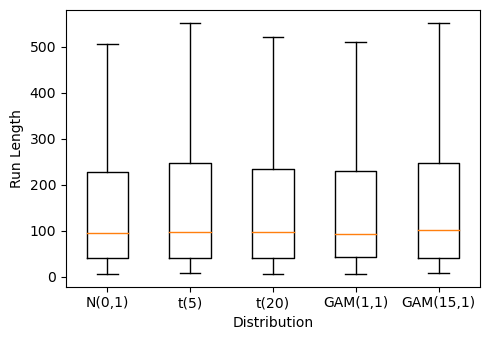

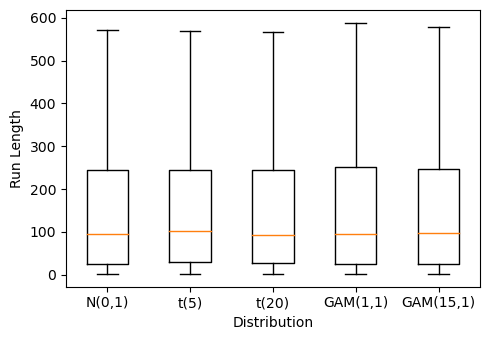

In [23]:
distribution_labels = {
    'normal (0)': 'N(0,1)',
    't (5)': 't(5)',
    't (20)': 't(20)',
    'gamma (1)': 'GAM(1,1)',
    'gamma (15)': 'GAM(15,1)'
}

for lambda_ in lambda_values:
    plt.figure(figsize=(5, 3.5))
    boxplot_data = results[results['Lambda'] == lambda_]
    data_to_plot = [boxplot_data[boxplot_data['Distribution'] == f'{dist} ({param1})']['Run_Length'] for dist, param1, _ in distributions]
    labels = [distribution_labels[f'{dist} ({param1})'] for dist, param1, _ in distributions]
    plt.boxplot(data_to_plot, labels=labels, sym='') 
    plt.xlabel('Distribution')
    plt.ylabel('Run Length')
    # plt.ylim(0, 300)
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'SSGR_{lambda_}_box.pdf')

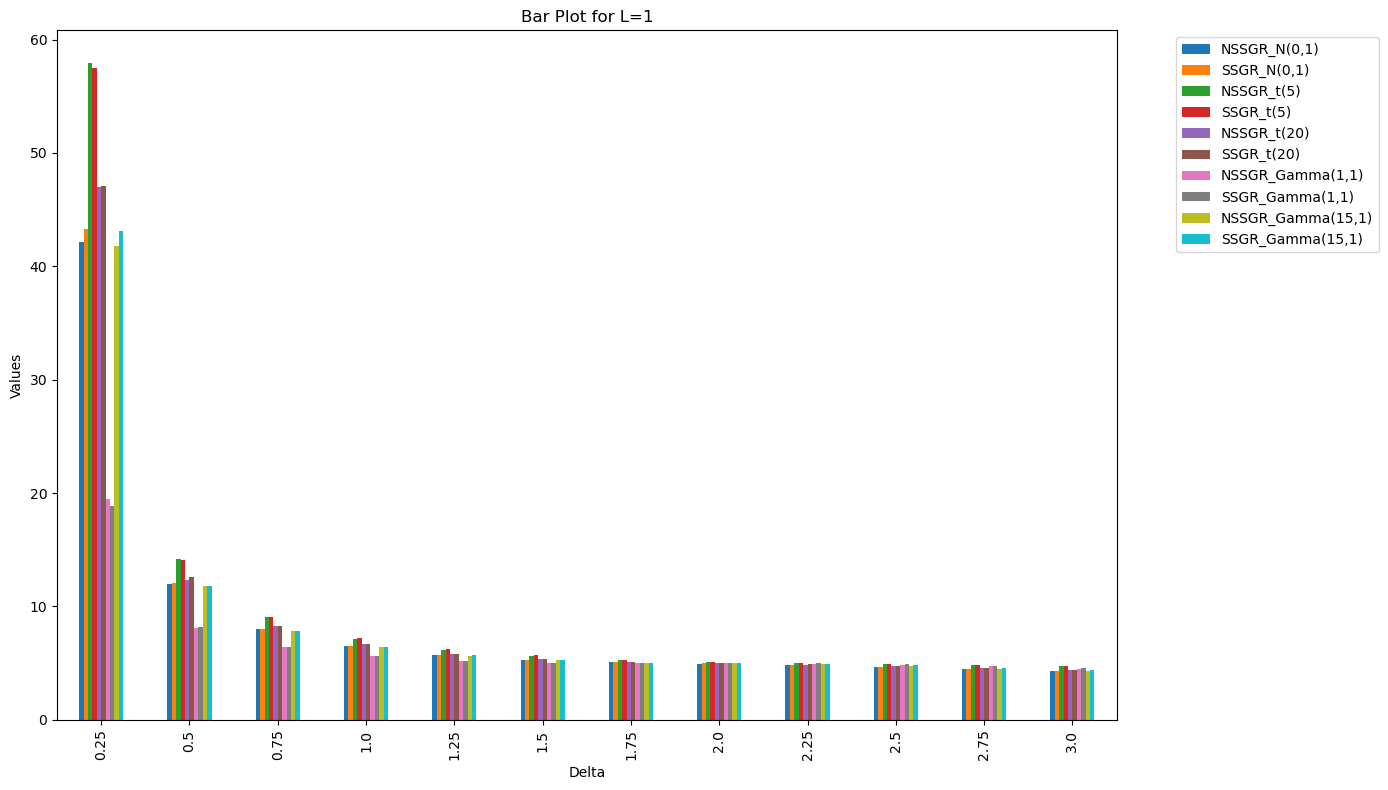

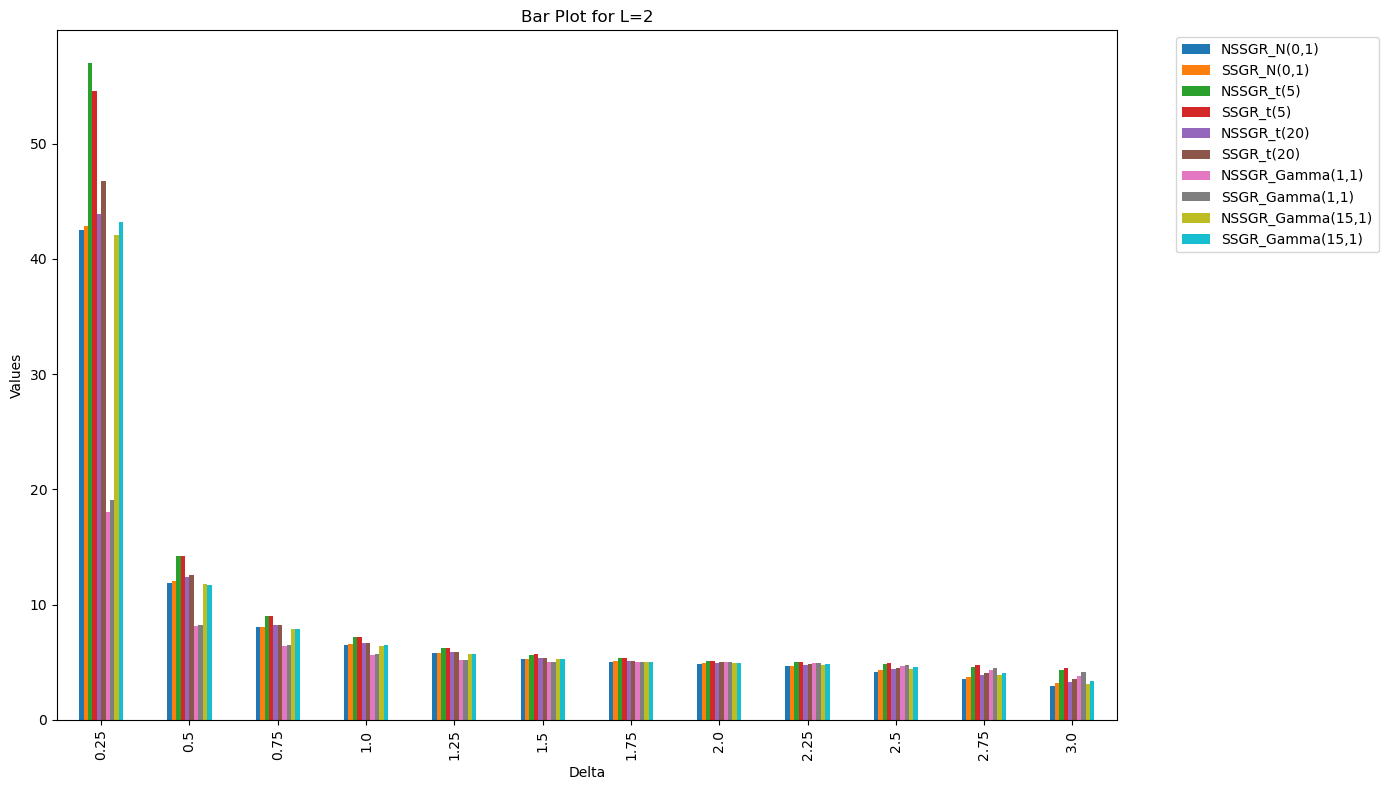

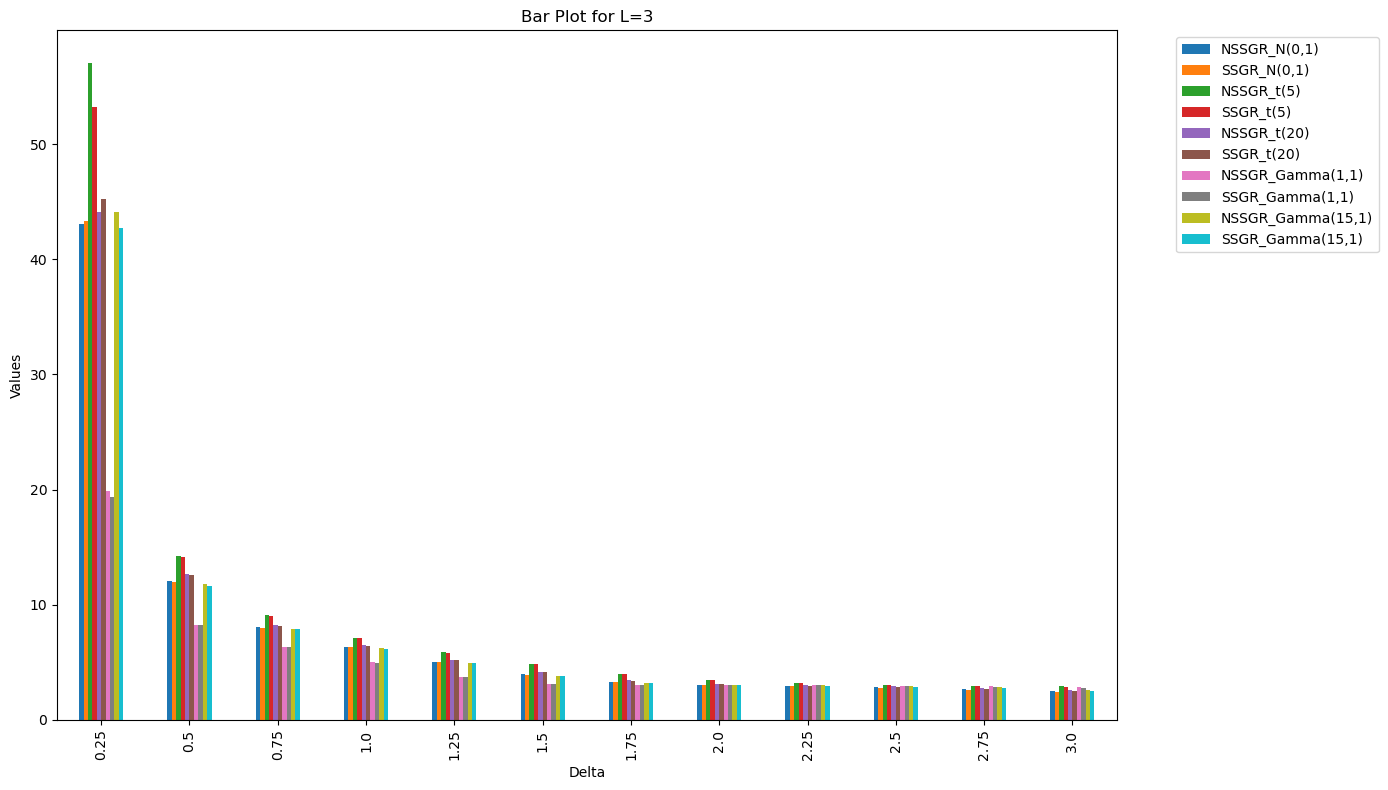

In [29]:
import pandas as pandas
import matplotlib.pyplot as plt

# Define the data for each value of L
data_L1 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [42.16, 12.00, 8.02, 6.48, 5.72, 5.28, 5.06, 4.95, 4.83, 4.66, 4.44, 4.26],
    "SSGR_N(0,1)": [43.33, 12.08, 8.02, 6.51, 5.74, 5.29, 5.07, 4.96, 4.85, 4.69, 4.49, 4.29],
    "NSSGR_t(5)": [57.92, 14.16, 9.04, 7.13, 6.19, 5.65, 5.30, 5.12, 5.01, 4.93, 4.83, 4.70],
    "SSGR_t(5)": [57.48, 14.09, 9.03, 7.17, 6.21, 5.67, 5.31, 5.13, 5.02, 4.95, 4.86, 4.75],
    "NSSGR_t(20)": [47.03, 12.35, 8.25, 6.65, 5.83, 5.36, 5.10, 4.98, 4.87, 4.74, 4.55, 4.37],
    "SSGR_t(20)": [47.05, 12.59, 8.26, 6.69, 5.84, 5.37, 5.11, 4.99, 4.90, 4.78, 4.60, 4.41],
    "NSSGR_Gamma(1,1)": [19.47, 8.13, 6.39, 5.63, 5.19, 5.02, 5.00, 4.99, 4.94, 4.84, 4.70, 4.49],
    "SSGR_Gamma(1,1)": [18.81, 8.16, 6.41, 5.66, 5.19, 5.03, 5.00, 4.99, 4.96, 4.89, 4.74, 4.58],
    "NSSGR_Gamma(15,1)": [41.79, 11.76, 7.82, 6.40, 5.65, 5.23, 5.04, 4.97, 4.90, 4.75, 4.51, 4.28],
    "SSGR_Gamma(15,1)": [43.08, 11.80, 7.87, 6.41, 5.67, 5.24, 5.04, 4.98, 4.92, 4.80, 4.59, 4.35]
}

data_L2 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [42.55, 11.91, 8.05, 6.51, 5.75, 5.29, 5.05, 4.87, 4.62, 4.12, 3.53, 2.96],
    "SSGR_N(0,1)": [42.88, 12.04, 8.07, 6.54, 5.76, 5.30, 5.06, 4.92, 4.70, 4.30, 3.74, 3.15],
    "NSSGR_t(5)": [56.99, 14.19, 8.96, 7.18, 6.21, 5.66, 5.32, 5.12, 4.99, 4.86, 4.60, 4.31],
    "SSGR_t(5)": [54.57, 14.21, 9.04, 7.21, 6.26, 5.68, 5.34, 5.13, 5.01, 4.89, 4.74, 4.47],
    "NSSGR_t(20)": [43.92, 12.39, 8.23, 6.66, 5.85, 5.38, 5.12, 4.94, 4.72, 4.38, 3.87, 3.28],
    "SSGR_t(20)": [46.78, 12.57, 8.22, 6.69, 5.88, 5.40, 5.13, 4.97, 4.81, 4.53, 4.07, 3.53],
    "NSSGR_Gamma(1,1)": [17.99, 8.17, 6.41, 5.66, 5.20, 5.03, 5.00, 4.98, 4.91, 4.69, 4.32, 3.82],
    "SSGR_Gamma(1,1)": [19.10, 8.20, 6.46, 5.70, 5.22, 5.04, 5.00, 4.98, 4.94, 4.79, 4.53, 4.11],
    "NSSGR_Gamma(15,1)": [42.11, 11.76, 7.86, 6.43, 5.68, 5.24, 5.04, 4.94, 4.78, 4.42, 3.85, 3.14],
    "SSGR_Gamma(15,1)": [43.16, 11.73, 7.88, 6.45, 5.70, 5.26, 5.04, 4.96, 4.86, 4.60, 4.09, 3.40]
}

# Completing the data entry for L3
data_L3 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [43.05, 12.09, 8.03, 6.34, 5.03, 3.96, 3.30, 3.03, 2.94, 2.84, 2.67, 2.48],
    "SSGR_N(0,1)": [43.29, 11.97, 8.01, 6.28, 4.99, 3.91, 3.26, 3.03, 2.92, 2.78, 2.61, 2.41],
    "NSSGR_t(5)": [57.04, 14.23, 9.07, 7.09, 5.88, 4.84, 4.00, 3.47, 3.18, 3.05, 2.96, 2.89],
    "SSGR_t(5)": [53.25, 14.15, 9.01, 7.06, 5.83, 4.82, 3.98, 3.46, 3.15, 3.02, 2.94, 2.85],
    "NSSGR_t(20)": [44.12, 12.64, 8.26, 6.49, 5.23, 4.18, 3.45, 3.10, 2.98, 2.90, 2.78, 2.61],
    "SSGR_t(20)": [45.20, 12.61, 8.17, 6.44, 5.20, 4.14, 3.39, 3.08, 2.96, 2.86, 2.71, 2.53],
    "NSSGR_Gamma(1,1)": [19.86, 8.27, 6.35, 5.05, 3.73, 3.13, 3.01, 3.00, 2.99, 2.96, 2.91, 2.81],
    "SSGR_Gamma(1,1)": [19.31, 8.20, 6.30, 4.96, 3.69, 3.11, 3.01, 3.00, 2.98, 2.94, 2.86, 2.73],
    "NSSGR_Gamma(15,1)": [44.10, 11.79, 7.87, 6.23, 4.92, 3.78, 3.18, 3.01, 2.98, 2.92, 2.80, 2.62],
    "SSGR_Gamma(15,1)": [42.69, 11.66, 7.84, 6.18, 4.89, 3.76, 3.17, 3.00, 2.96, 2.88, 2.73, 2.51]
}

# Convert data to DataFrame
df_L1 = pandas.DataFrame(data_L1)
df_L2 = pandas.DataFrame(data_L2)
df_L3 = pandas.DataFrame(data_L3)

# Plotting function
def plot_data(df, L_value):
    fig, ax = plt.subplots(figsize=(14, 8))
    df.plot(x="Delta", kind="bar", ax=ax)
    ax.set_title(f'Bar Plot for L={L_value}')
    ax.set_xlabel('Delta')
    ax.set_ylabel('Values')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot data for L1, L2, and L3
plot_data(df_L1, 1)
plot_data(df_L2, 2)
plot_data(df_L3, 3)


# Lambda = 0.05

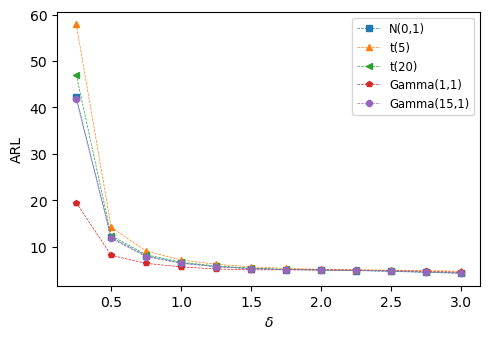

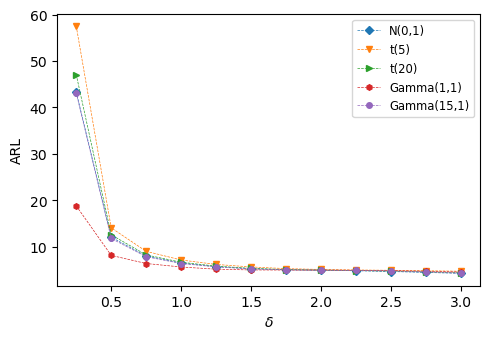

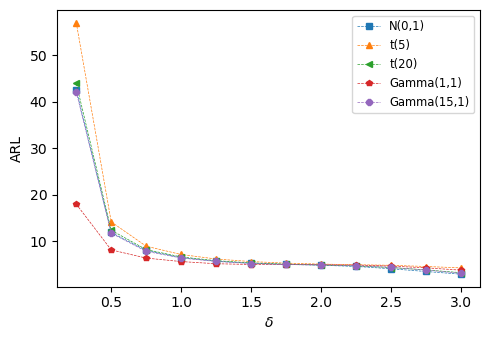

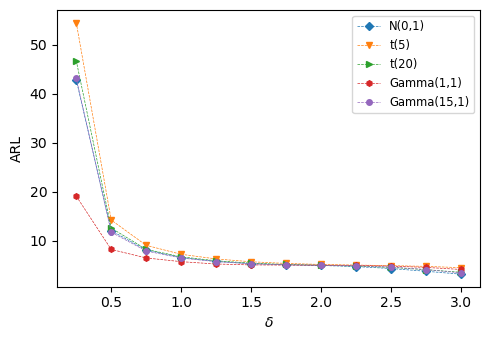

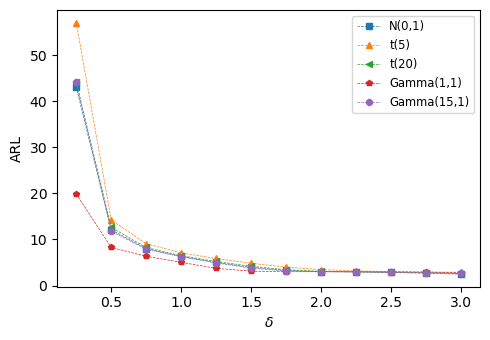

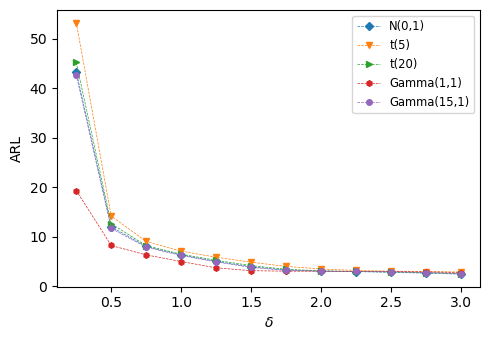

In [59]:
import pandas as pandas
import matplotlib.pyplot as plt

# Data for L=1
data_L1 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [42.16, 12.00, 8.02, 6.48, 5.72, 5.28, 5.06, 4.95, 4.83, 4.66, 4.44, 4.26],
    "SSGR_N(0,1)": [43.33, 12.08, 8.02, 6.51, 5.74, 5.29, 5.07, 4.96, 4.85, 4.69, 4.49, 4.29],
    "NSSGR_t(5)": [57.92, 14.16, 9.04, 7.13, 6.19, 5.65, 5.30, 5.12, 5.01, 4.93, 4.83, 4.70],
    "SSGR_t(5)": [57.48, 14.09, 9.03, 7.17, 6.21, 5.67, 5.31, 5.13, 5.02, 4.95, 4.86, 4.75],
    "NSSGR_t(20)": [47.03, 12.35, 8.25, 6.65, 5.83, 5.36, 5.10, 4.98, 4.87, 4.74, 4.55, 4.37],
    "SSGR_t(20)": [47.05, 12.59, 8.26, 6.69, 5.84, 5.37, 5.11, 4.99, 4.90, 4.78, 4.60, 4.41],
    "NSSGR_Gamma(1,1)": [19.47, 8.13, 6.39, 5.63, 5.19, 5.02, 5.00, 4.99, 4.94, 4.84, 4.70, 4.49],
    "SSGR_Gamma(1,1)": [18.81, 8.16, 6.41, 5.66, 5.19, 5.03, 5.00, 4.99, 4.96, 4.89, 4.74, 4.58],
    "NSSGR_Gamma(15,1)": [41.79, 11.76, 7.82, 6.40, 5.65, 5.23, 5.04, 4.97, 4.90, 4.75, 4.51, 4.28],
    "SSGR_Gamma(15,1)": [43.08, 11.80, 7.87, 6.41, 5.67, 5.24, 5.04, 4.98, 4.92, 4.80, 4.59, 4.35]
}

# Data for L=2
data_L2 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [42.55, 11.91, 8.05, 6.51, 5.75, 5.29, 5.05, 4.87, 4.62, 4.12, 3.53, 2.96],
    "SSGR_N(0,1)": [42.88, 12.04, 8.07, 6.54, 5.76, 5.30, 5.06, 4.92, 4.70, 4.30, 3.74, 3.15],
    "NSSGR_t(5)": [56.99, 14.19, 8.96, 7.18, 6.21, 5.66, 5.32, 5.12, 4.99, 4.86, 4.60, 4.31],
    "SSGR_t(5)": [54.57, 14.21, 9.04, 7.21, 6.26, 5.68, 5.34, 5.13, 5.01, 4.89, 4.74, 4.47],
    "NSSGR_t(20)": [43.92, 12.39, 8.23, 6.66, 5.85, 5.38, 5.12, 4.94, 4.72, 4.38, 3.87, 3.28],
    "SSGR_t(20)": [46.78, 12.57, 8.22, 6.69, 5.88, 5.40, 5.13, 4.97, 4.81, 4.53, 4.07, 3.53],
    "NSSGR_Gamma(1,1)": [17.99, 8.17, 6.41, 5.66, 5.20, 5.03, 5.00, 4.98, 4.91, 4.69, 4.32, 3.82],
    "SSGR_Gamma(1,1)": [19.10, 8.20, 6.46, 5.70, 5.22, 5.04, 5.00, 4.98, 4.94, 4.79, 4.53, 4.11],
    "NSSGR_Gamma(15,1)": [42.11, 11.76, 7.86, 6.43, 5.68, 5.24, 5.04, 4.94, 4.78, 4.42, 3.85, 3.14],
    "SSGR_Gamma(15,1)": [43.16, 11.73, 7.88, 6.45, 5.70, 5.26, 5.04, 4.96, 4.86, 4.60, 4.09, 3.40]
}

# Data for L=3
data_L3 = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [43.05, 12.09, 8.03, 6.34, 5.03, 3.96, 3.30, 3.03, 2.94, 2.84, 2.67, 2.48],
    "SSGR_N(0,1)": [43.29, 11.97, 8.01, 6.28, 4.99, 3.91, 3.26, 3.03, 2.92, 2.78, 2.61, 2.41],
    "NSSGR_t(5)": [57.04, 14.23, 9.07, 7.09, 5.88, 4.84, 4.00, 3.47, 3.18, 3.05, 2.96, 2.89],
    "SSGR_t(5)": [53.25, 14.15, 9.01, 7.06, 5.83, 4.82, 3.98, 3.46, 3.15, 3.02, 2.94, 2.85],
    "NSSGR_t(20)": [44.12, 12.64, 8.26, 6.49, 5.23, 4.18, 3.45, 3.10, 2.98, 2.90, 2.78, 2.61],
    "SSGR_t(20)": [45.20, 12.61, 8.17, 6.44, 5.20, 4.14, 3.39, 3.08, 2.96, 2.86, 2.71, 2.53],
    "NSSGR_Gamma(1,1)": [19.86, 8.27, 6.35, 5.05, 3.73, 3.13, 3.01, 3.00, 2.99, 2.96, 2.91, 2.81],
    "SSGR_Gamma(1,1)": [19.31, 8.20, 6.30, 4.96, 3.69, 3.11, 3.01, 3.00, 2.98, 2.94, 2.86, 2.73],
    "NSSGR_Gamma(15,1)": [44.10, 11.79, 7.87, 6.23, 4.92, 3.78, 3.18, 3.01, 2.98, 2.92, 2.80, 2.62],
    "SSGR_Gamma(15,1)": [42.69, 11.66, 7.84, 6.18, 4.89, 3.76, 3.17, 3.00, 2.96, 2.88, 2.73, 2.51]
}

# Convert dictionaries to dataframes
df_L1 = pandas.DataFrame(data_L1)
df_L2 = pandas.DataFrame(data_L2)
df_L3 = pandas.DataFrame(data_L3)

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

# Function to plot data
def plot_data_separately(df, L):
    # Plot NSSGR
    plt.figure(figsize=(5, 3.5))
    for i, col in enumerate(df.columns):
        if col.startswith('NSSGR'):
            plt.plot(df['Delta'], df[col], marker=markers[i % len(markers)], label=col.split('_')[1], linestyle = '--', linewidth = 0.5, markersize = 4)
    # plt.title(f'L={L} - NSSGR')
    plt.xlabel('$\delta$')
    plt.ylabel('ARL')
    plt.legend(fontsize = 'small')
    # plt.xticks([0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3])
    plt.tight_layout()
    plt.savefig(f'{L}_NSSGR_5.pdf')
    # Plot SSGR
    plt.figure(figsize=(5, 3.5))
    for i, col in enumerate(df.columns):
        if col.startswith('SSGR'):
            plt.plot(df['Delta'], df[col], marker=markers[i % len(markers)], label=col.split('_')[1], linestyle = '--', linewidth = 0.5, markersize = 4)
    # plt.title(f'L={L} - SSGR')
    plt.xlabel('$\delta$')
    plt.ylabel('ARL')
    plt.legend(fontsize= 'small')
    plt.tight_layout()
    plt.savefig(f'{L}_SSGR_5.pdf')

plot_data_separately(df_L1, 1)
plot_data_separately(df_L2, 2)
plot_data_separately(df_L3, 3)


# Lambda = 0.5

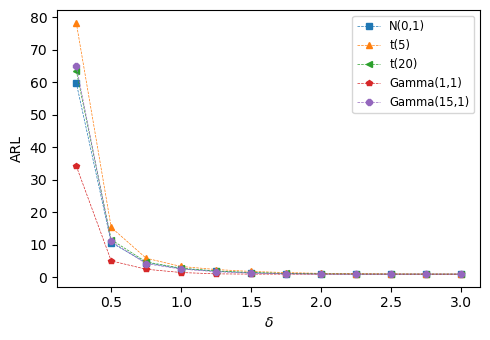

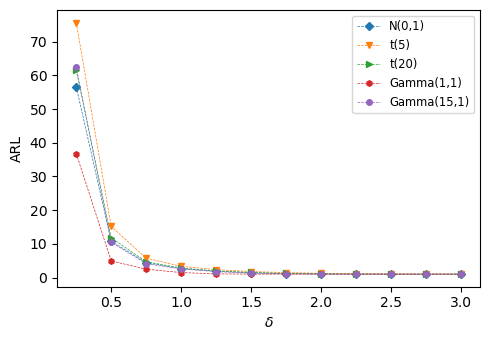

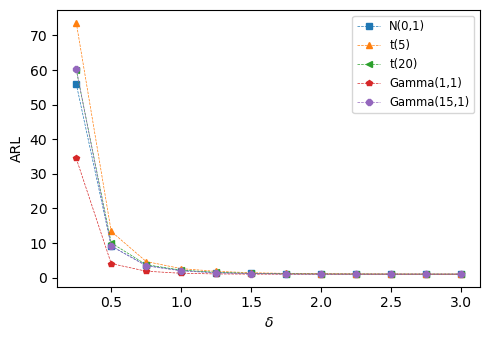

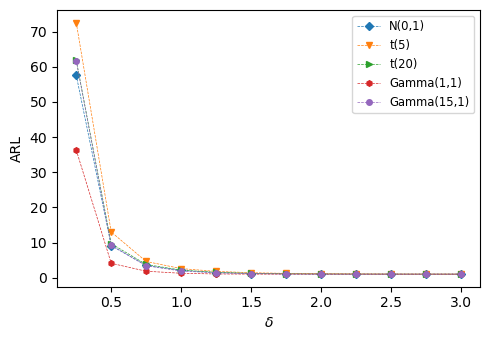

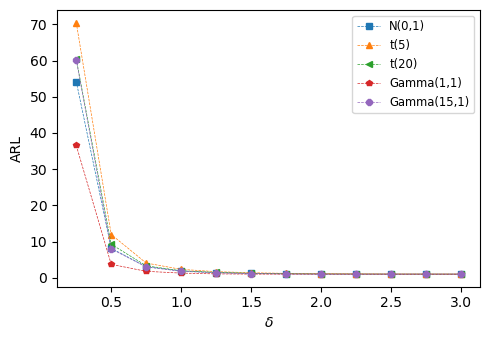

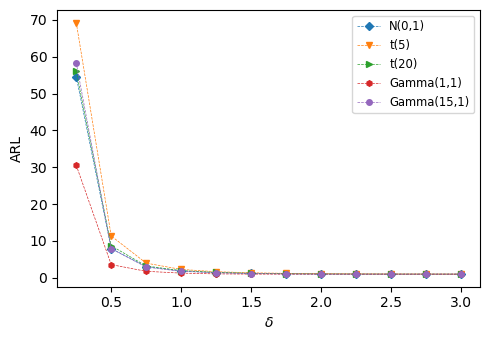

In [60]:
data_L1_second_term = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [59.91, 10.68, 4.53, 2.68, 1.90, 1.43, 1.17, 1.06, 1.02, 1.004, 1.009, 1.0003],
    "SSGR_N(0,1)": [56.65, 10.78, 4.40, 2.67, 1.88, 1.41, 1.17, 1.06, 1.02, 1.002, 1.0006, 1.00],
    "NSSGR_t(5)": [78.43, 15.39, 5.9043, 3.36, 2.42, 1.83, 1.48, 1.24, 1.14, 1.07, 1.03, 1.02],
    "SSGR_t(5)": [75.71, 15.17, 5.74, 3.34, 2.34, 1.78, 1.46, 1.25, 1.14, 1.08, 1.04, 1.02],
    "NSSGR_t(20)": [63.64, 11.61, 4.75, 2.86, 1.99, 1.50, 1.24, 1.09, 1.03, 1.009, 1.004, 1.0009],
    "SSGR_t(20)": [61.64, 11.78, 4.68, 2.81, 1.97, 1.51, 1.22, 1.09, 1.03, 1.01, 1.004, 1.002],
    "NSSGR_Gamma(1,1)": [34.30, 5.09, 2.51, 1.50, 1.09, 1.007, 1.0003, 1.00, 1.00, 1.00, 1.00, 1.00],
    "SSGR_Gamma(1,1)": [36.80, 4.92, 2.47, 1.47, 1.08, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "NSSGR_Gamma(15,1)": [65.06, 11.06, 4.22, 2.56, 1.75, 1.30, 1.08, 1.01, 1.0006, 1.00, 1.00, 1.00],
    "SSGR_Gamma(15,1)": [62.47, 10.49, 4.10, 2.55, 1.74, 1.28, 1.07, 1.01, 1.00, 1.00, 1.00, 1.00]
}

data_L2_second_term = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [55.98, 9.13, 3.53, 2.05, 1.45, 1.20, 1.08, 1.03, 1.01, 1.002, 1.0004, 1.0004],
    "SSGR_N(0,1)": [57.58, 9.12, 3.47, 2.04, 1.45, 1.18, 1.08, 1.03, 1.01, 1.00, 1.00, 1.00],
    "NSSGR_t(5)": [73.73, 13.36, 4.65, 2.60, 1.81, 1.41, 1.22, 1.12, 1.07, 1.04, 1.02, 1.01],
    "SSGR_t(5)": [72.58, 13.00, 4.60, 2.58, 1.78, 1.41, 1.22, 1.12, 1.07, 1.03, 1.02, 1.01],
    "NSSGR_t(20)": [60.09, 10.05, 3.73, 2.17, 1.52, 1.23, 1.11, 1.04, 1.02, 1.005, 1.002, 1.0007],
    "SSGR_t(20)": [61.86, 9.67, 3.75, 2.15, 1.52, 1.24, 1.11, 1.04, 1.02, 1.01, 1.00, 1.00],
    "NSSGR_Gamma(1,1)": [34.45, 4.06, 1.85, 1.25, 1.06, 1.006, 1.0003, 1.00, 1.00, 1.00, 1.00, 1.00],
    "SSGR_Gamma(1,1)": [36.30, 4.09, 1.83, 1.25, 1.05, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "NSSGR_Gamma(15,1)": [60.37, 9.12, 3.39, 1.94, 1.36, 1.14, 1.04, 1.01, 1.001, 1.00, 1.00, 1.00],
    "SSGR_Gamma(15,1)": [61.71, 9.19, 3.38, 1.88, 1.37, 1.13, 1.04, 1.01, 1.00, 1.00, 1.00, 1.00]
}

data_L3_second_term = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "NSSGR_N(0,1)": [54.21, 8.14, 3.06, 1.87, 1.42, 1.20, 1.09, 1.03, 1.01, 1.002, 1.0007, 1.0002],
    "SSGR_N(0,1)": [54.59, 7.94, 3.06, 1.85, 1.42, 1.19, 1.09, 1.03, 1.01, 1.00, 1.00, 1.00],
    "NSSGR_t(5)": [70.49, 11.95, 4.07, 2.32, 1.69, 1.39, 1.22, 1.13, 1.08, 1.04, 1.03, 1.02],
    "SSGR_t(5)": [69.28, 11.36, 3.99, 2.28, 1.66, 1.37, 1.22, 1.12, 1.07, 1.04, 1.03, 1.01],
    "NSSGR_t(20)": [60.43, 9.26, 3.30, 1.94, 1.48, 1.25, 1.12, 1.05, 1.02, 1.01, 1.00, 1.00],
    "SSGR_t(20)": [56.02, 8.70, 3.21, 1.97, 1.47, 1.24, 1.11, 1.05, 1.02, 1.01, 1.00, 1.00],
    "NSSGR_Gamma(1,1)": [36.54, 3.71, 1.78, 1.29, 1.07, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "SSGR_Gamma(1,1)": [30.54, 3.59, 1.77, 1.28, 1.07, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "NSSGR_Gamma(15,1)": [60.16, 7.98, 2.98, 1.79, 1.36, 1.15, 1.05, 1.01, 1.00, 1.00, 1.00, 1.00],
    "SSGR_Gamma(15,1)": [58.32, 7.90, 2.91, 1.76, 1.36, 1.15, 1.05, 1.01, 1.00, 1.00, 1.00, 1.00]
}


df_L1 = pandas.DataFrame(data_L1_second_term)
df_L2 = pandas.DataFrame(data_L2_second_term)
df_L3 = pandas.DataFrame(data_L3_second_term)

plot_data_separately(df_L1, 1)
plot_data_separately(df_L2, 2)
plot_data_separately(df_L3, 3)

# Comparison with existing charts

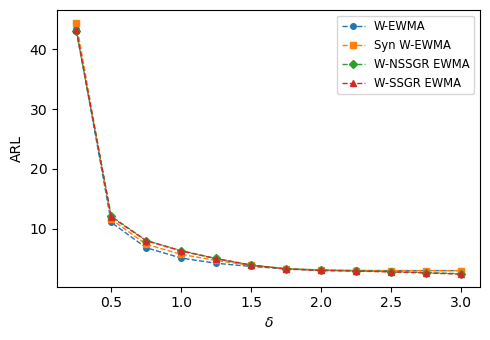

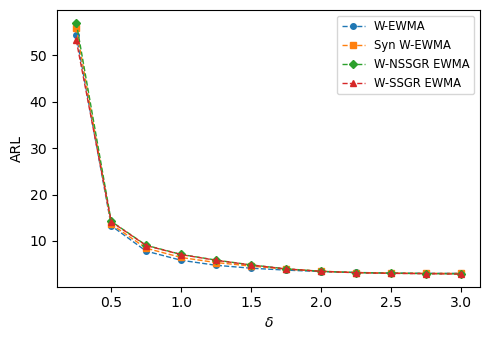

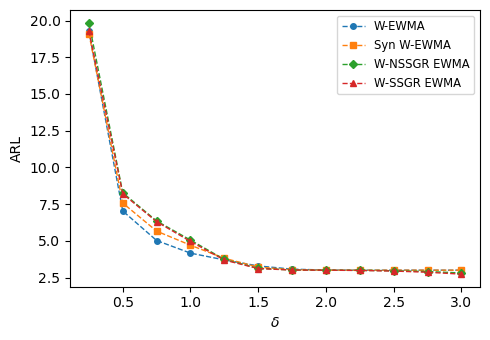

In [73]:
import matplotlib.pyplot as plt

data = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "W-EWMA_N(0,1)": [43.44, 11.06, 6.83, 5.10, 4.23, 3.69, 3.31, 3.11, 3.02, 3.00, 3.00, 3.00],
    "Syn W-EWMA_N(0,1)": [44.46, 11.56, 7.40, 5.72, 4.70, 3.88, 3.33, 3.09, 3.01, 3.00, 3.00, 3.00],
    "W-NSSGR EWMA_N(0,1)": [43.05, 12.09, 8.03, 6.34, 5.03, 3.96, 3.30, 3.03, 2.94, 2.84, 2.67, 2.48],
    "W-SSGR EWMA_N(0,1)": [43.29, 11.97, 8.01, 6.28, 4.99, 3.91, 3.26, 3.03, 2.92, 2.78, 2.61, 2.41],
    "W-EWMA_t(5)": [54.35, 13.28, 7.81, 5.84, 4.76, 4.13, 3.72, 3.41, 3.21, 3.09, 3.04, 3.02],
    "Syn W-EWMA_t(5)": [55.90, 13.61, 8.44, 6.44, 5.35, 4.58, 3.94, 3.48, 3.20, 3.08, 3.03, 3.01],
    "W-NSSGR EWMA_t(5)": [57.04, 14.23, 9.07, 7.09, 5.88, 4.84, 4.00, 3.47, 3.18, 3.05, 2.96, 2.89],
    "W-SSGR EWMA_t(5)": [53.25, 14.15, 9.01, 7.06, 5.83, 4.82, 3.98, 3.46, 3.15, 3.02, 2.94, 2.85],
    "W-EWMA_Gamma(1,1)": [19.26, 7.03, 5.02, 4.16, 3.70, 3.29, 3.07, 3.01, 3.00, 3.00, 3.00, 3.00],
    "Syn W-EWMA_Gamma(1,1)": [19.11, 7.57, 5.66, 4.70, 3.81, 3.21, 3.03, 3.00, 3.00, 3.00, 3.00, 3.00],
    "W-NSSGR EWMA_Gamma(1,1)": [19.86, 8.27, 6.35, 5.05, 3.73, 3.13, 3.01, 3.00, 2.99, 2.96, 2.91, 2.81],
    "W-SSGR EWMA_Gamma(1,1)": [19.31, 8.20, 6.30, 4.96, 3.69, 3.11, 3.01, 3.00, 2.98, 2.94, 2.86, 2.73]
}

# Convert data to a pandas DataFrame
import pandas as pandas
df = pandas.DataFrame(data)

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

# Plotting the data for each distribution
def plot_distribution(distribution):
    plt.figure(figsize=(5, 3.5))
    columns = [col for col in df.columns if distribution in col]
    for i, col in enumerate(columns):
        plt.plot(df['Delta'], df[col], marker=markers[i % len(markers)], label=col.split('_')[0], linewidth=1, linestyle = '--', markersize = 4)
    # plt.title(f'Performance of {distribution}')
    plt.xlabel('$\delta$')
    plt.ylabel('ARL')
    plt.legend(fontsize = 'small')
    plt.tight_layout()
    plt.savefig(f'{distribution}_0_5.pdf')

# Plot for N(0,1)
plot_distribution('N(0,1)')

# Plot for t(5)
plot_distribution('t(5)')

# Plot for Gamma(1,1)
plot_distribution('Gamma(1,1)')


# Lambda 0.5

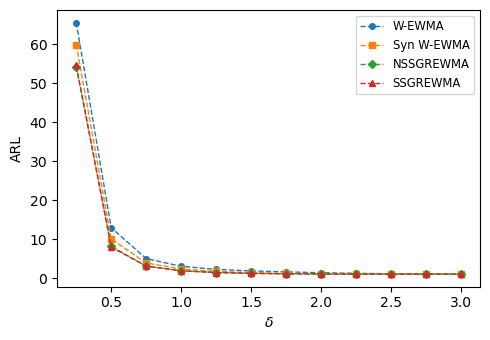

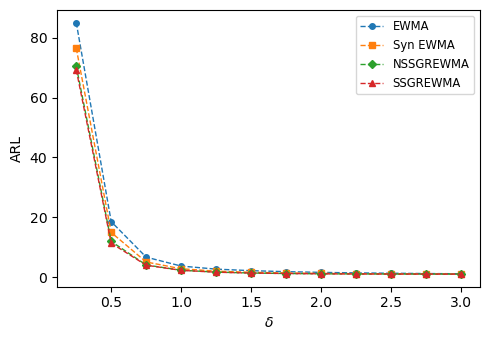

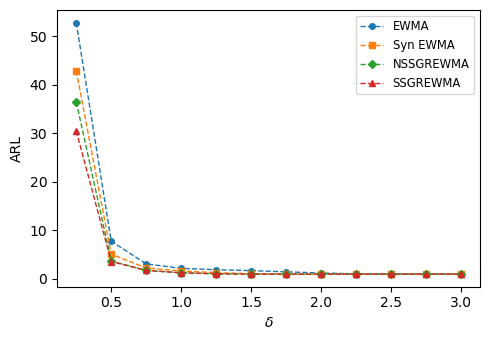

In [74]:
import matplotlib.pyplot as plt

data_second_term = {
    "Delta": [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00],
    "W-EWMA_N(0,1)": [65.55, 12.91, 4.99, 3.01, 2.22, 1.83, 1.58, 1.36, 1.21, 1.11, 1.05, 1.02],
    "Syn W-EWMA_N(0,1)": [59.92, 10.04, 3.87, 2.31, 1.69, 1.40, 1.20, 1.10, 1.04, 1.01, 1.00, 1.00],
    "NSSGREWMA_N(0,1)": [54.21, 8.14, 3.06, 1.87, 1.42, 1.20, 1.09, 1.03, 1.01, 1.002, 1.0007, 1.0002],
    "SSGREWMA_N(0,1)": [54.59, 7.94, 3.06, 1.85, 1.42, 1.19, 1.09, 1.03, 1.01, 1.00, 1.00, 1.00],
    "EWMA_t(5)": [85.07, 18.55, 6.69, 3.71, 2.69, 2.17, 1.84, 1.60, 1.43, 1.31, 1.21, 1.14],
    "Syn EWMA_t(5)": [76.53, 14.94, 5.07, 2.81, 2.01, 1.63, 1.40, 1.26, 1.17, 1.10, 1.07, 1.04],
    "NSSGREWMA_t(5)": [70.49, 11.95, 4.07, 2.32, 1.69, 1.39, 1.22, 1.13, 1.08, 1.04, 1.03, 1.02],
    "SSGREWMA_t(5)": [69.28, 11.36, 3.99, 2.28, 1.66, 1.37, 1.22, 1.12, 1.07, 1.04, 1.03, 1.01],
    "EWMA_Gamma(1,1)": [52.87, 7.81, 3.12, 2.19, 1.92, 1.72, 1.48, 1.23, 1.08, 1.02, 1.00, 1.00],
    "Syn EWMA_Gamma(1,1)": [42.94, 5.11, 2.27, 1.66, 1.31, 1.09, 1.02, 1.00, 1.00, 1.00, 1.00, 1.00],
    "NSSGREWMA_Gamma(1,1)": [36.54, 3.71, 1.78, 1.29, 1.07, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "SSGREWMA_Gamma(1,1)": [30.54, 3.59, 1.77, 1.28, 1.07, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
}

# Convert data to a pandas DataFrame
import pandas as pandas
df = pandas.DataFrame(data_second_term)

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

# Plotting the data for each distribution
# def plot_distribution(distribution):
#     plt.figure(figsize=(5, 3.5))
#     columns = [col for col in df.columns if distribution in col]
#     for i, col in enumerate(columns):
#         plt.plot(df['Delta'], df[col], marker=markers[i % len(markers)], label=col.split('_')[0], linewidth=1, linestyle = '--', markersize = 4)
#     # plt.title(f'Performance of {distribution}')
#     plt.xlabel('Delta')
#     plt.ylabel('Value')
#     plt.legend(fontsize = 'small')
#     plt.tight_layout()

# Plot for N(0,1)
plot_distribution('N(0,1)')

# Plot for t(5)
plot_distribution('t(5)')

# Plot for Gamma(1,1)
plot_distribution('Gamma(1,1)')


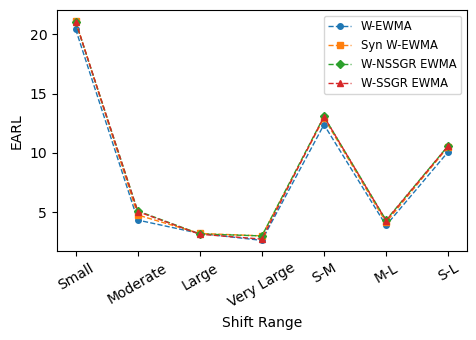

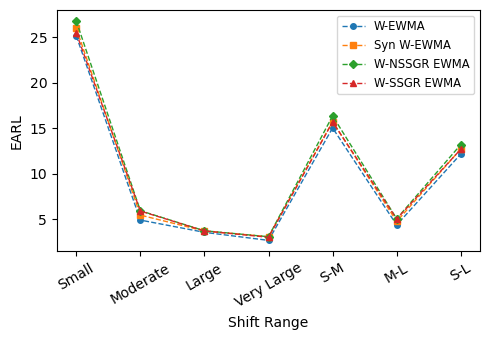

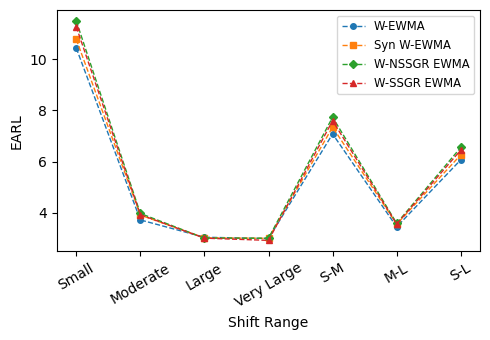

In [91]:
import matplotlib.pyplot as plt
import pandas as pandas

data = {
    "Shift Range": ["Small", "Moderate", "Large", "Very Large", "S-M", "M-L", "S-L"],
    "W-EWMA_N(0,1)": [20.44333333, 4.34, 3.21, 2.625, 12.39166667, 3.888, 10.09625],
    "Syn W-EWMA_N(0,1)": [21.14, 4.766666667, 3.21, 3.005, 12.95333333, 4.144, 10.5175],
    "W-NSSGR EWMA_N(0,1)": [21.05666667, 5.11, 3.165, 3.0025, 13.08333333, 4.332, 10.60375],
    "W-SSGR EWMA_N(0,1)": [21.09, 5.06, 3.145, 2.7325, 13.075, 4.294, 10.5925],
    "W-EWMA_t(5)": [25.14666667, 4.91, 3.565, 2.68, 15.02833333, 4.372, 12.1625],
    "Syn W-EWMA_t(5)": [25.98333333, 5.456666667, 3.71, 3.09, 15.72, 4.758, 12.7175],
    "W-NSSGR EWMA_t(5)": [26.78, 5.936666667, 3.735, 3.08, 16.35833333, 5.056, 13.2025],
    "W-SSGR EWMA_t(5)": [25.47, 5.903333333, 3.72, 3.02, 15.68666667, 5.03, 12.695],
    "W-EWMA_Gamma(1,1)": [10.43666667, 3.716666667, 3.04, 2.99, 7.076666667, 3.446, 6.0675],
    "Syn W-EWMA_Gamma(1,1)": [10.78, 3.906666667, 3.015, 3, 7.343333333, 3.55, 6.26125],
    "W-NSSGR EWMA_Gamma(1,1)": [11.49333333, 3.97, 3.005, 3, 7.731666667, 3.584, 6.55],
    "W-SSGR EWMA_Gamma(1,1)": [11.27, 3.92, 3.005, 2.9175, 7.595, 3.554, 6.4475]
}

# Convert data to a pandas DataFrame
df = pandas.DataFrame(data)

# Define marker styles for different charts
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

# Plotting function
def plot_distribution(distribution):
    plt.figure(figsize=(5, 3.5))
    columns = [col for col in df.columns if distribution in col]
    for i, col in enumerate(columns):
        plt.plot(df['Shift Range'], df[col], marker=markers[i % len(markers)], label=col.split('_')[0], linewidth=1, linestyle='--', markersize = 4)
    # plt.title(f'Performance of {distribution}')
    plt.xlabel('Shift Range')
    plt.ylabel('EARL')
    plt.legend(fontsize= 'small')
    plt.xticks(rotation=30)
    # plt.grid(True)
    # plt.show()
    plt.tight_layout()
    plt.savefig(f'{distribution}.pdf')

# Plot for N(0,1)
plot_distribution('N(0,1)')

# Plot for t(5)
plot_distribution('t(5)')

# Plot for Gamma(1,1)
plot_distribution('Gamma(1,1)')


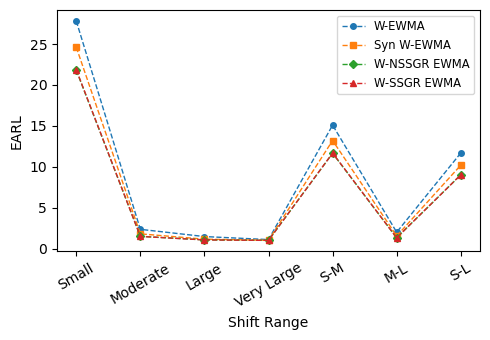

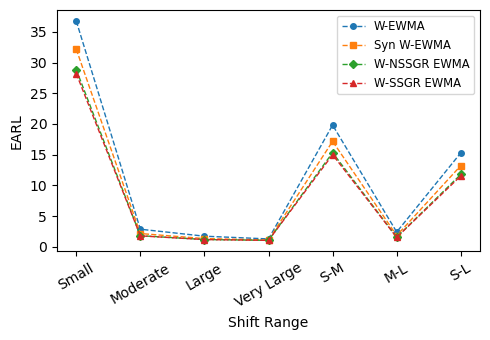

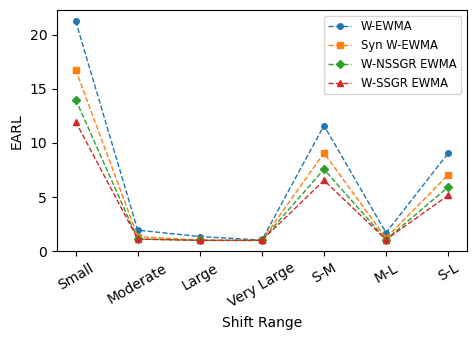

In [89]:
import matplotlib.pyplot as plt
import pandas as pandas

data2 = {
    "Shift Range": ["Small", "Moderate", "Large", "Very Large", "S-M", "M-L", "S-L"],
    "W-EWMA_N(0,1)": [27.81666667, 2.353333333, 1.47, 1.0975, 15.085, 2, 11.68125],
    "Syn W-EWMA_N(0,1)": [24.61, 1.8, 1.15, 1.0125, 13.205, 1.54, 10.19125],
    "W-NSSGR EWMA_N(0,1)": [21.80333333, 1.496666667, 1.06, 1.003225, 11.65, 1.322, 9.0025],
    "W-SSGR EWMA_N(0,1)": [21.86333333, 1.486666667, 1.06, 1.0025, 11.675, 1.316, 9.02125],
    "W-EWMA_t(5)": [36.77, 2.856666667, 1.72, 1.2725, 19.81333333, 2.402, 15.29],
    "Syn W-EWMA_t(5)": [32.18, 2.15, 1.33, 1.095, 17.165, 1.822, 13.20625],
    "W-NSSGR EWMA_t(5)": [28.83666667, 1.8, 1.175, 1.0425, 15.31833333, 1.55, 11.7825],
    "W-SSGR EWMA_t(5)": [28.21, 1.77, 1.17, 1.0375, 14.99, 1.53, 11.535],
    "W-EWMA_Gamma(1,1)": [21.26666667, 1.943333333, 1.355, 1.025, 11.605, 1.708, 9.0425],
    "Syn W-EWMA_Gamma(1,1)": [16.77333333, 1.353333333, 1.01, 1, 9.063333333, 1.216, 7.05],
    "W-NSSGR EWMA_Gamma(1,1)": [14.01, 1.123333333, 1, 1, 7.566666667, 1.074, 5.925],
    "W-SSGR EWMA_Gamma(1,1)": [11.96666667, 1.12, 1, 1, 6.543333333, 1.072, 5.1575]
}

# Convert data to a pandas DataFrame
df2 = pandas.DataFrame(data2)

# Define marker styles for different charts
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

# Plotting function
def plot_distribution2(distribution):
    plt.figure(figsize=(5, 3.5))
    columns = [col for col in df2.columns if distribution in col]
    for i, col in enumerate(columns):
        plt.plot(df2['Shift Range'], df2[col], marker=markers[i % len(markers)], label=col.split('_')[0], linewidth=1, linestyle='--', markersize = 4)
    # plt.title(f'Performance of {distribution}')
    plt.xlabel('Shift Range')
    plt.ylabel('EARL')
    plt.legend(fontsize = 'small')
    plt.xticks(rotation=30)
    # plt.grid(True)
    # plt.show()
    plt.tight_layout()
    # plt.savefig(f'{distribution}_0_5.pdf')
# Plot for N(0,1)
plot_distribution2('N(0,1)')

# Plot for t(5)
plot_distribution2('t(5)')

# Plot for Gamma(1,1)
plot_distribution2('Gamma(1,1)')


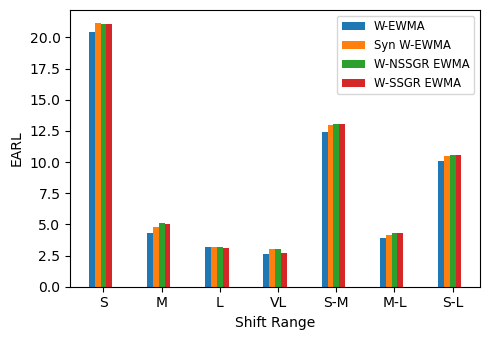

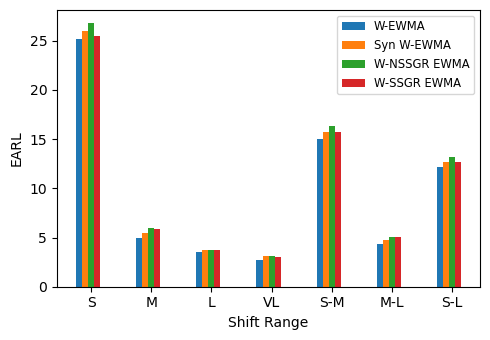

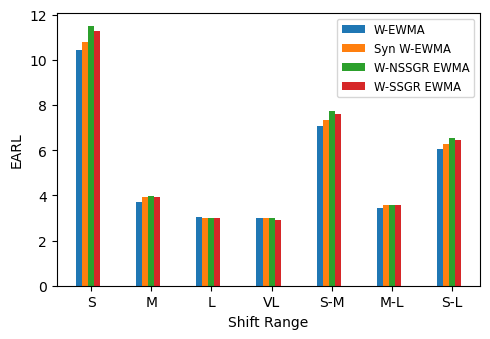

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    "Shift Range": ["S", "M", "L", "VL", "S-M", "M-L", "S-L"],
    "W-EWMA_N(0,1)": [20.44333333, 4.34, 3.21, 2.625, 12.39166667, 3.888, 10.09625],
    "Syn W-EWMA_N(0,1)": [21.14, 4.766666667, 3.21, 3.005, 12.95333333, 4.144, 10.5175],
    "W-NSSGR EWMA_N(0,1)": [21.05666667, 5.11, 3.165, 3.0025, 13.08333333, 4.332, 10.60375],
    "W-SSGR EWMA_N(0,1)": [21.09, 5.06, 3.145, 2.7325, 13.075, 4.294, 10.5925],
    "W-EWMA_t(5)": [25.14666667, 4.91, 3.565, 2.68, 15.02833333, 4.372, 12.1625],
    "Syn W-EWMA_t(5)": [25.98333333, 5.456666667, 3.71, 3.09, 15.72, 4.758, 12.7175],
    "W-NSSGR EWMA_t(5)": [26.78, 5.936666667, 3.735, 3.08, 16.35833333, 5.056, 13.2025],
    "W-SSGR EWMA_t(5)": [25.47, 5.903333333, 3.72, 3.02, 15.68666667, 5.03, 12.695],
    "W-EWMA_Gamma(1,1)": [10.43666667, 3.716666667, 3.04, 2.99, 7.076666667, 3.446, 6.0675],
    "Syn W-EWMA_Gamma(1,1)": [10.78, 3.906666667, 3.015, 3, 7.343333333, 3.55, 6.26125],
    "W-NSSGR EWMA_Gamma(1,1)": [11.49333333, 3.97, 3.005, 3, 7.731666667, 3.584, 6.55],
    "W-SSGR EWMA_Gamma(1,1)": [11.27, 3.92, 3.005, 2.9175, 7.595, 3.554, 6.4475]
}

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Plotting function for bar charts
def plot_distribution_bar(distribution):
    plt.figure(figsize=(5, 3.5))
    columns = [col for col in df.columns if distribution in col]
    bar_width = 0.1
    index = np.arange(len(df['Shift Range']))
    
    for i, col in enumerate(columns):
        plt.bar(index + i * bar_width, df[col], bar_width, label=col.split('_')[0])

    plt.xlabel('Shift Range')
    plt.ylabel('EARL')
    # plt.title(f'Performance of {distribution}')
    plt.xticks(index + bar_width * (len(columns) / 2), df['Shift Range'], rotation=0)
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig(f'{distribution}.pdf')

# Plot for N(0,1)
plot_distribution_bar('N(0,1)')

# Plot for t(5)
plot_distribution_bar('t(5)')

# Plot for Gamma(1,1)
plot_distribution_bar('Gamma(1,1)')


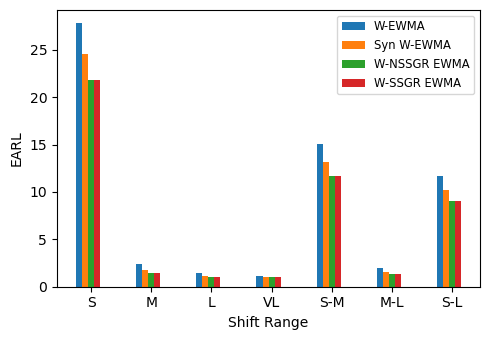

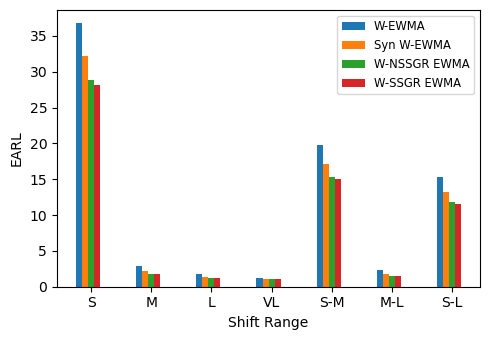

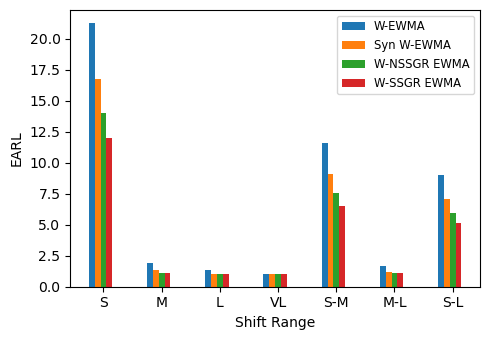

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data2 = {
    "Shift Range": ["S", "M", "L", "VL", "S-M", "M-L", "S-L"],
    "W-EWMA_N(0,1)": [27.81666667, 2.353333333, 1.47, 1.0975, 15.085, 2, 11.68125],
    "Syn W-EWMA_N(0,1)": [24.61, 1.8, 1.15, 1.0125, 13.205, 1.54, 10.19125],
    "W-NSSGR EWMA_N(0,1)": [21.80333333, 1.496666667, 1.06, 1.003225, 11.65, 1.322, 9.0025],
    "W-SSGR EWMA_N(0,1)": [21.86333333, 1.486666667, 1.06, 1.0025, 11.675, 1.316, 9.02125],
    "W-EWMA_t(5)": [36.77, 2.856666667, 1.72, 1.2725, 19.81333333, 2.402, 15.29],
    "Syn W-EWMA_t(5)": [32.18, 2.15, 1.33, 1.095, 17.165, 1.822, 13.20625],
    "W-NSSGR EWMA_t(5)": [28.83666667, 1.8, 1.175, 1.0425, 15.31833333, 1.55, 11.7825],
    "W-SSGR EWMA_t(5)": [28.21, 1.77, 1.17, 1.0375, 14.99, 1.53, 11.535],
    "W-EWMA_Gamma(1,1)": [21.26666667, 1.943333333, 1.355, 1.025, 11.605, 1.708, 9.0425],
    "Syn W-EWMA_Gamma(1,1)": [16.77333333, 1.353333333, 1.01, 1, 9.063333333, 1.216, 7.05],
    "W-NSSGR EWMA_Gamma(1,1)": [14.01, 1.123333333, 1, 1, 7.566666667, 1.074, 5.925],
    "W-SSGR EWMA_Gamma(1,1)": [11.96666667, 1.12, 1, 1, 6.543333333, 1.072, 5.1575]
}

# Convert data to a pandas DataFrame
df2 = pd.DataFrame(data2)

# Plotting function for bar charts
def plot_distribution_bar2(distribution):
    plt.figure(figsize=(5, 3.5))
    columns = [col for col in df2.columns if distribution in col]
    bar_width = 0.1
    index = np.arange(len(df2['Shift Range']))
    
    for i, col in enumerate(columns):
        plt.bar(index + i * bar_width, df2[col], bar_width, label=col.split('_')[0])

    plt.xlabel('Shift Range')
    plt.ylabel('EARL')
    # plt.title(f'Performance of {distribution}')
    plt.xticks(index + bar_width * (len(columns) / 2), df2['Shift Range'], rotation=0)
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig(f'{distribution}_0_5.pdf')

# Plot for N(0,1)
plot_distribution_bar2('N(0,1)')

# Plot for t(5)
plot_distribution_bar2('t(5)')

# Plot for Gamma(1,1)
plot_distribution_bar2('Gamma(1,1)')
